In [1]:
# Libraries
import itertools
from importlib import resources
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

from drdt.helper_functions import DecisionRuleCreatorFromDecisionTable, Reduction, R_SR, R_AD, SAlphaStep, SPlus, SMax, NCover, NGreedy
from drdt.algorithms import DynamicProgrammingAlgorithms, A_C_N, A_C_G
from drdt.helper_functions import DecisionRuleCreatorFromDecisionTable
pd.options.mode.chained_assignment = None


In [2]:
problems = ['AR', 'EAR', 'SR', 'ESR', 'AD', 'EAD']
dataset_name = "Breast Cancer"

DP = []
NC = []
NCgreedy = []
Gr = []

# Loading Data

In [3]:
# Loading DecisionTable
breast_cancer = fetch_ucirepo(id=14) 

X = breast_cancer.data.features 
y = breast_cancer.data.targets 

#rename target name 'Class' to 'class'
y = y.rename(columns={'Class': 'class'})

DecisionTable = pd.concat([X, y], axis=1).sample(n=25, random_state=123)
DecisionTable

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,class
240,60-69,ge40,20-24,5-Mar,no,2,left,left_low,yes,recurrence-events
29,60-69,ge40,30-34,0-2,no,2,left,left_low,no,no-recurrence-events
269,40-49,premeno,25-29,0-2,no,2,left,left_low,yes,recurrence-events
79,40-49,premeno,25-29,0-2,no,2,right,central,no,no-recurrence-events
210,40-49,premeno,20-24,0-2,no,2,left,left_low,no,recurrence-events
282,30-39,premeno,20-24,0-2,no,3,left,left_up,yes,recurrence-events
231,40-49,premeno,30-34,5-Mar,no,2,right,left_up,no,recurrence-events
219,30-39,premeno,15-19,0-2,no,1,right,left_low,no,recurrence-events
132,40-49,premeno,30-34,8-Jun,no,2,left,left_up,no,no-recurrence-events
260,60-69,ge40,25-29,5-Mar,no,2,right,right_up,no,recurrence-events


In [4]:
# Creating Decision Rule System
S = DecisionRuleCreatorFromDecisionTable(DecisionTable).applymap(lambda x: str(x) if pd.notnull(x) else x)
S = S.dropna(axis=1, how='all') # Drop the columns with all None
S

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 502.78it/s]


,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,class
240,NaN,NaN,20-24,NaN,NaN,NaN,NaN,NaN,recurrence-events
29,60-69,NaN,30-34,NaN,NaN,NaN,NaN,NaN,no-recurrence-events
269,NaN,NaN,25-29,NaN,NaN,NaN,left,NaN,recurrence-events
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,central,no-recurrence-events
210,NaN,NaN,20-24,NaN,NaN,NaN,NaN,NaN,recurrence-events
282,NaN,NaN,20-24,NaN,NaN,NaN,NaN,NaN,recurrence-events
231,40-49,NaN,NaN,5-Mar,NaN,NaN,NaN,NaN,recurrence-events
219,30-39,NaN,15-19,NaN,NaN,NaN,NaN,NaN,recurrence-events
132,NaN,NaN,NaN,8-Jun,NaN,NaN,NaN,NaN,no-recurrence-events
260,NaN,NaN,NaN,5-Mar,no,NaN,NaN,NaN,recurrence-events


# Dataset Analyses

In [5]:
n = len(S.columns)-1
print(f"Number of features  = {n}")

Number of features  = 8


In [6]:
print(f"Does # of features = d  = {not S.dropna().empty}")

Does # of features = d  = False


In [7]:
# Count non-NaN values for each row
non_nan_counts = S.count(axis=1)

# Find the index
max_non_nan_row_index = non_nan_counts.idxmax()

# Retrieve the row
max_non_nan_row = S.loc[max_non_nan_row_index]

# Number of non-NaN values in the row
max_non_nan_count = non_nan_counts[max_non_nan_row_index]

d = max_non_nan_count - 1

print(f"d = {d}") # remove 1 because of last class column

d = 2


In [8]:
P = S
P_plus = SPlus(P)
B = NCover(P_plus)
print(f"Length of Node Cover for AR = {len(B)}")

Length of Node Cover for AR = 4


In [9]:
P = R_SR(S)
P_plus = SPlus(P)
B = NCover(P_plus)
print(f"Length of Node Cover for SR = {len(B)}")

Length of Node Cover for SR = 0


In [10]:
P = R_AD(S)
P_plus = SPlus(P)
B = NCover(P_plus)
print(f"Length of Node Cover for AD = {len(B)}")

Length of Node Cover for AD = 4


In [11]:
P = S
P_plus = SPlus(P)
B = NGreedy(P_plus)
print(f"Length of Node Cover greedy for AR = {len(B)}")

Length of Node Cover greedy for AR = 3


In [12]:
P = R_SR(S)
P_plus = SPlus(P)
B = NGreedy(P_plus)
print(f"Length of Node Cover greedy for SR = {len(B)}")

Length of Node Cover greedy for SR = 0


In [13]:
P = R_AD(S)
P_plus = SPlus(P)
B = NGreedy(P_plus)
print(f"Length of Node Cover greedy for AD = {len(B)}")

Length of Node Cover greedy for AD = 3


# Dynamic Programming

In [14]:
alg = DynamicProgrammingAlgorithms(C="AR")
depth = alg.A_DP(S)
DP.append(depth)
print(f"DP AR = {depth}")

DP AR = 8


In [15]:
alg = DynamicProgrammingAlgorithms(C="EAR")
depth = alg.A_DP(S)
DP.append(depth)
print(f"DP EAR = {depth}")

DP EAR = 8


In [16]:
alg = DynamicProgrammingAlgorithms(C="SR")
depth = alg.A_DP(S)
DP.append(depth)
print(f"DP SR = {depth}")

DP SR = 0


In [17]:
alg = DynamicProgrammingAlgorithms(C="ESR")
depth = alg.A_DP(S)
DP.append(depth)
print(f"DP ESR = {depth}")

DP ESR = 0


In [18]:
alg = DynamicProgrammingAlgorithms(C="AD")
depth = alg.A_DP(S)
DP.append(depth)
print(f"DP AD = {depth}")

DP AD = 3


In [19]:
alg = DynamicProgrammingAlgorithms(C="EAD")
depth = alg.A_DP(S)
DP.append(depth)
print(f"DP EAD = {depth}")

DP EAD = 5


# Combinations

In [20]:
column_values = []

for column in S.columns[:-1]: #ignoring class column
    column_values.append(list(S[column].dropna().unique()))
    
# All possible combinations    
combinations = list(itertools.product(*column_values))


In [21]:
column_values_extension = []

for column in S.columns[:-1]: #ignoring class column
    column_values_extension.append(list(S[column].dropna().unique()) + ['*'])
    
# All possible combinations with extension    
extended_combinations = list(itertools.product(*column_values_extension))


# Node Cover

In [22]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NC AR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|████████████████████████████████████████| 288/288 [00:02<00:00, 117.30it/s]

NC AR
(Max Depth, Min Depth, Average Depth) = (8, 5, 5.694444444444445)


In [23]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NC EAR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|████████████████████████████████████| 12000/12000 [01:35<00:00, 125.86it/s]

NC EAR
(Max Depth, Min Depth, Average Depth) = (8, 5, 5.58)


In [24]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="SR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NC SR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████████| 288/288 [00:03<00:00, 80.36it/s]

NC SR
(Max Depth, Min Depth, Average Depth) = (0, 0, 0.0)


In [25]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="ESR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NC ESR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████| 12000/12000 [02:25<00:00, 82.59it/s]

NC ESR
(Max Depth, Min Depth, Average Depth) = (0, 0, 0.0)


In [26]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AD", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NC AD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████████| 288/288 [00:04<00:00, 60.66it/s]

NC AD
(Max Depth, Min Depth, Average Depth) = (5, 4, 4.138888888888889)


In [27]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAD", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NC EAD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████| 12000/12000 [03:05<00:00, 64.69it/s]

NC EAD
(Max Depth, Min Depth, Average Depth) = (5, 4, 4.132)


# Node Cover Greedy

In [28]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NCgreedy AR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████████| 288/288 [00:03<00:00, 84.62it/s]

NCgreedy AR
(Max Depth, Min Depth, Average Depth) = (8, 4, 4.944444444444445)


In [29]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NCgreedy EAR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████| 12000/12000 [02:09<00:00, 92.65it/s]

NCgreedy EAR
(Max Depth, Min Depth, Average Depth) = (8, 4, 4.78)


In [30]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="SR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NCgreedy SR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████████| 288/288 [00:03<00:00, 82.88it/s]

NCgreedy SR
(Max Depth, Min Depth, Average Depth) = (0, 0, 0.0)


In [31]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="ESR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NCgreedy ESR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████| 12000/12000 [02:19<00:00, 85.95it/s]

NCgreedy ESR
(Max Depth, Min Depth, Average Depth) = (0, 0, 0.0)


In [32]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AD", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NCgreedy AD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████████| 288/288 [00:05<00:00, 54.99it/s]

NCgreedy AD
(Max Depth, Min Depth, Average Depth) = (5, 3, 3.2569444444444446)


In [33]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAD", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("NCgreedy EAD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████| 12000/12000 [03:31<00:00, 56.64it/s]

NCgreedy EAD
(Max Depth, Min Depth, Average Depth) = (5, 3, 3.232)


# Greedy

In [34]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="AR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("Greedy AR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|████████████████████████████████████████| 288/288 [00:01<00:00, 165.96it/s]

Greedy AR
(Max Depth, Min Depth, Average Depth) = (8, 4, 4.944444444444445)


In [35]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="EAR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("Greedy EAR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|████████████████████████████████████| 12000/12000 [01:04<00:00, 186.82it/s]

Greedy EAR
(Max Depth, Min Depth, Average Depth) = (8, 4, 4.78)


In [36]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="SR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("Greedy SR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████████| 288/288 [00:03<00:00, 84.02it/s]

Greedy SR
(Max Depth, Min Depth, Average Depth) = (0, 0, 0.0)


In [37]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="ESR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("Greedy ESR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████| 12000/12000 [02:19<00:00, 86.14it/s]

Greedy ESR
(Max Depth, Min Depth, Average Depth) = (0, 0, 0.0)


In [38]:
depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="AD")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("Greedy AD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████████| 288/288 [00:04<00:00, 63.72it/s]

Greedy AD
(Max Depth, Min Depth, Average Depth) = (4, 2, 3.0972222222222223)


In [39]:
depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="EAD")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
print("Greedy EAD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))

100%|█████████████████████████████████████| 12000/12000 [03:02<00:00, 65.86it/s]

Greedy EAD
(Max Depth, Min Depth, Average Depth) = (5, 2, 3.104)


# PLOTS

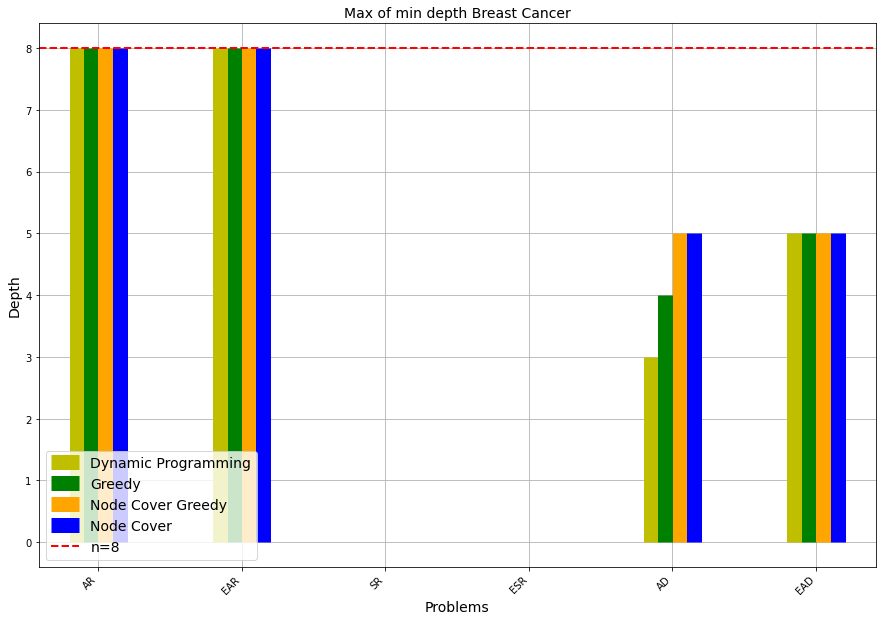

In [40]:
problem_indices = np.arange(len(problems))

plt.figure(figsize=(15,10))

offset = 0.1
x_offsets = np.array([-1.5*offset, -0.5*offset, 0.5*offset, 1.5*offset])

plt.vlines(problem_indices + x_offsets[0], 0, DP, color='y', linewidth=15, label='Dynamic Programming')
plt.vlines(problem_indices + x_offsets[1], 0, [a for a,_,_ in Gr], color='g', linewidth=15, label='Greedy')
plt.vlines(problem_indices + x_offsets[2], 0, [a for a,_,_ in NCgreedy], color='orange', linewidth=15, label='Node Cover Greedy')
plt.vlines(problem_indices + x_offsets[3], 0, [a for a,_,_ in NC], color='b', linewidth=15, label='Node Cover')

plt.axhline(y=n, color='r', linestyle='--', linewidth=2, label=f'n={n}')

plt.xticks(problem_indices, problems, rotation=45, ha='right')

plt.title(f'Max of min depth {dataset_name}', fontsize=14)
plt.xlabel('Problems', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()


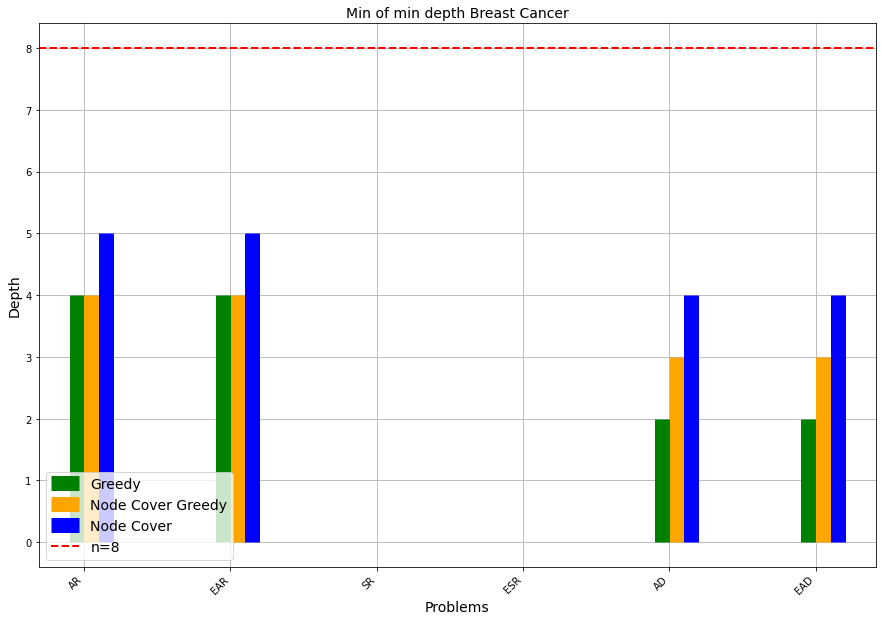

In [41]:
problem_indices = np.arange(len(problems))

plt.figure(figsize=(15,10))

offset = 0.1
x_offsets = np.array([-1.5*offset, -0.5*offset, 0.5*offset, 1.5*offset])

plt.vlines(problem_indices + x_offsets[1], 0, [a for _,a,_ in Gr], color='g', linewidth=15, label='Greedy')
plt.vlines(problem_indices + x_offsets[2], 0, [a for _,a,_ in NCgreedy], color='orange', linewidth=15, label='Node Cover Greedy')
plt.vlines(problem_indices + x_offsets[3], 0, [a for _,a,_ in NC], color='b', linewidth=15, label='Node Cover')

plt.axhline(y=n, color='r', linestyle='--', linewidth=2, label=f'n={n}')

plt.xticks(problem_indices, problems, rotation=45, ha='right')

plt.title(f'Min of min depth {dataset_name}', fontsize=14)
plt.xlabel('Problems', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()

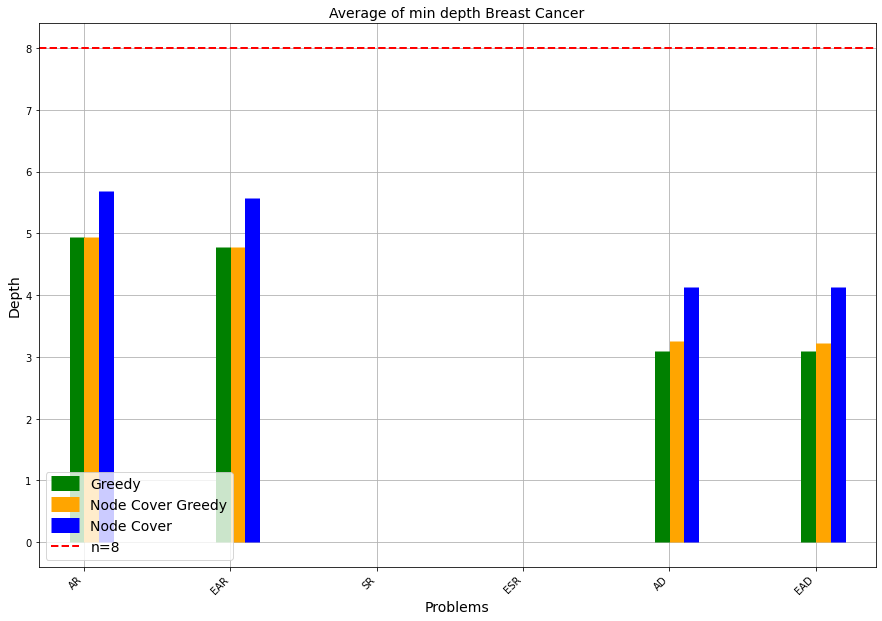

In [42]:
problem_indices = np.arange(len(problems))

plt.figure(figsize=(15,10))

offset = 0.1
x_offsets = np.array([-1.5*offset, -0.5*offset, 0.5*offset, 1.5*offset])

plt.vlines(problem_indices + x_offsets[1], 0, [a for _,_,a in Gr], color='g', linewidth=15, label='Greedy')
plt.vlines(problem_indices + x_offsets[2], 0, [a for _,_,a in NCgreedy], color='orange', linewidth=15, label='Node Cover Greedy')
plt.vlines(problem_indices + x_offsets[3], 0, [a for _,_,a in NC], color='b', linewidth=15, label='Node Cover')

plt.axhline(y=n, color='r', linestyle='--', linewidth=2, label=f'n={n}')

plt.xticks(problem_indices, problems, rotation=45, ha='right')

plt.title(f'Average of min depth {dataset_name}', fontsize=14)
plt.xlabel('Problems', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()